## _*NaH dissociation curve using VQE with UCCSD*_

This notebook demonstrates using the Qiskit Chemistry to plot graphs of the ground state energy of the Sodium Hydride (NaH) molecule over a range of inter-atomic distances using VQE and UCCSD. It is compared to the same energies as computed by the ExactEigensolver.

_*Note: this molecule is larger than the similar LiH and this notebook can take a while to run.*_

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

molecule = 'H .0 .0 -{0}; Na .0 .0 {0}'
algorithms = ['VQE', 'ExactEigensolver']

pts  = [x * 0.1  for x in range(10, 25)]
pts += [x * 0.25 for x in range(10, 18)]
pts += [4.5]
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
dipoles     = np.empty([len(algorithms), len(pts)])
eval_counts = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    for j in range(len(algorithms)):
        driver = PySCFDriver(atom=molecule.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                                two_qubit_reduction=True,
                                freeze_core=True, orbital_reduction=[])
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j] == 'ExactEigensolver':
            result = ExactEigensolver(qubit_op, aux_operators=aux_ops).run()
        else:
            optimizer = SLSQP(maxiter=2500)
            initial_state = HartreeFock(qubit_op.num_qubits,
                                        operator.molecule_info['num_orbitals'],
                                        operator.molecule_info['num_particles'],
                                        qubit_mapping=operator._qubit_mapping,
                                        two_qubit_reduction=operator._two_qubit_reduction)
            var_form = UCCSD(qubit_op.num_qubits, depth=1,
                            num_orbitals=operator.molecule_info['num_orbitals'],
                            num_particles=operator.molecule_info['num_particles'],
                            initial_state=initial_state,
                            qubit_mapping=operator._qubit_mapping,
                            two_qubit_reduction=operator._two_qubit_reduction)
            algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
                              
        lines, result = operator.process_algorithm_result(result)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        dipoles[j][i]  = result['total_dipole_moment'] / 0.393430307
        if algorithms[j] == 'VQE':
            eval_counts[i] = result['algorithm_retvals']['eval_count']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('Dipoles:', dipoles)
print('VQE num evaluations:', eval_counts)


Couldn't find cython int routine
Couldn't find cython int routine
Processing step 23 --- complete
Distances:  [1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3
 2.4  2.5  2.75 3.   3.25 3.5  3.75 4.   4.25 4.5 ]
Energies: [[-160.05849063 -160.15699836 -160.22568735 -160.27202139 -160.30172252
  -160.31895083 -160.32675432 -160.32741528 -160.32269878 -160.31400273
  -160.30245852 -160.28899051 -160.27435538 -160.2591661  -160.2439109
  -160.2289718  -160.19475711 -160.16708758 -160.14746338 -160.13627128
  -160.13114984 -160.12788151 -160.12587996 -160.06078205]
 [-160.05849084 -160.15699856 -160.22568741 -160.2720216  -160.30172261
  -160.31895199 -160.32675458 -160.32741545 -160.32269886 -160.31400297
  -160.30245861 -160.28899063 -160.27435552 -160.25916618 -160.24391112
  -160.22897222 -160.19475719 -160.16708762 -160.14746354 -160.13627173
  -160.13150727 -160.12988489 -160.12941537 -160.12738873]]
Hartree-Fock energies: [-160.04320295 -160.14360744 -160.2133673

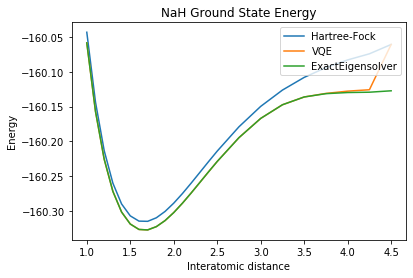

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('NaH Ground State Energy')
pylab.legend(loc='upper right');

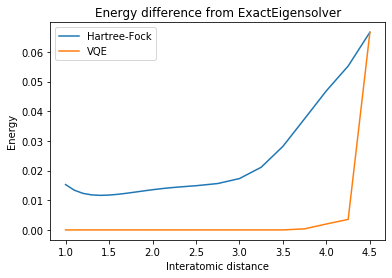

In [3]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper left');

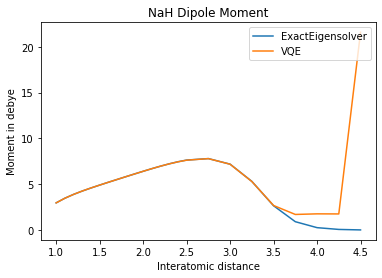

In [4]:
for j in reversed(range(len(algorithms))):
    pylab.plot(distances, dipoles[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Moment in debye')
pylab.title('NaH Dipole Moment')
pylab.legend(loc='upper right');

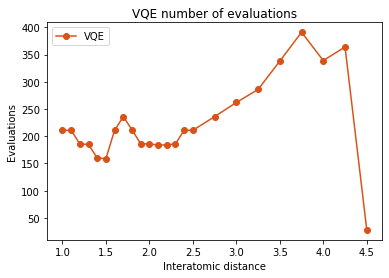

In [5]:
pylab.plot(distances, eval_counts, '-o', color=[0.8500, 0.3250, 0.0980], label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='upper left');